In [ ]:
def plot_multiple_firms_single_model(gvkeys, model_name='GARCH', maturity=5):
    """
    Plot time series comparison for multiple firms using a single model.
    """
    market_map = {1: cds_1y, 3: cds_3y, 5: cds_5y}
    model_map = {'Merton': merton_cds, 'GARCH': garch_cds, 
                 'Regime Switching': rs_cds, 'MS-GARCH': msgarch_cds}
    
    if maturity not in market_map or model_name not in model_map:
        print(f"Invalid maturity or model name")
        return
    
    market_df = market_map[maturity]
    model_df = model_map[model_name]
    
    # Create grid
    n_firms = len(gvkeys)
    n_cols = 3
    n_rows = (n_firms + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, gvkey in enumerate(gvkeys):
        if idx >= len(axes):
            break
            
        # Get firm name
        firm_data = market_df[market_df['gvkey'] == gvkey]
        if len(firm_data) == 0:
            axes[idx].text(0.5, 0.5, f'No data for gvkey {gvkey}', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue
        
        firm_name = firm_data['company'].iloc[0] if 'company' in firm_data.columns else f'Firm {gvkey}'
        
        # Prepare comparison
        comparison = prepare_cds_comparison(gvkey, maturity, market_df, model_df, model_name)
        
        if len(comparison) == 0:
            axes[idx].text(0.5, 0.5, f'No model data', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue
        
        # Plot
        axes[idx].plot(comparison['date'], comparison['market_cds'], 
                      label='Market', color='black', linewidth=2, alpha=0.7)
        axes[idx].plot(comparison['date'], comparison['model_cds'], 
                      label=model_name, color='red', linewidth=1.5, linestyle='--')
        
        axes[idx].set_title(f'{firm_name} ({gvkey})', fontsize=10)
        axes[idx].set_xlabel('Date', fontsize=8)
        axes[idx].set_ylabel('CDS Spread (bps)', fontsize=8)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='both', labelsize=8)
        
        # Add metrics
        corr = comparison[['market_cds', 'model_cds']].corr().iloc[0, 1]
        rmse = np.sqrt(((comparison['market_cds'] - comparison['model_cds']) ** 2).mean())
        axes[idx].text(0.02, 0.98, f'ρ={corr:.2f}\\nRMSE={rmse:.0f}',
                      transform=axes[idx].transAxes, fontsize=7,
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide unused subplots
    for idx in range(n_firms, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'{model_name} Model vs Market CDS ({maturity}Y Maturity)', fontsize=14, y=1.002)
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / f'cds_comparison_multiple_firms_{model_name}_{maturity}y.png', 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'✓ Saved: cds_comparison_multiple_firms_{model_name}_{maturity}y.png')

print('✓ Multi-firm plotting function defined')

### Example Firm Comparison

You can compare any firm's market CDS spreads with model-implied spreads by changing the `gvkey` parameter.

Common firms in the dataset:
- **220833**: Example firm (change to actual firm name if known)
- **14447**: Another example firm

Change the `maturity` parameter to 1, 3, or 5 years to see different maturities.

In [ ]:
def plot_firm_cds_comparison(gvkey, maturity=5, models=['Merton', 'GARCH', 'Regime Switching', 'MS-GARCH']):
    """
    Plot time series comparison of market vs model CDS spreads for a single firm.
    """
    # Map maturity to market data
    market_map = {1: cds_1y, 3: cds_3y, 5: cds_5y}
    model_map = {'Merton': merton_cds, 'GARCH': garch_cds, 
                 'Regime Switching': rs_cds, 'MS-GARCH': msgarch_cds}
    
    if maturity not in market_map:
        print(f"Invalid maturity {maturity}. Choose from 1, 3, or 5.")
        return
    
    market_df = market_map[maturity]
    
    # Get firm name
    firm_data = market_df[market_df['gvkey'] == gvkey]
    if len(firm_data) == 0:
        print(f"No data found for gvkey {gvkey}")
        return
    
    firm_name = firm_data['company'].iloc[0] if 'company' in firm_data.columns else f'Firm {gvkey}'
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, model_name in enumerate(models):
        if model_name not in model_map:
            continue
            
        model_df = model_map[model_name]
        
        # Prepare comparison data
        comparison = prepare_cds_comparison(gvkey, maturity, market_df, model_df, model_name)
        
        if len(comparison) == 0:
            axes[idx].text(0.5, 0.5, f'No data for {model_name}', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            continue
        
        # Plot
        axes[idx].plot(comparison['date'], comparison['market_cds'], 
                      label='Market CDS', color='black', linewidth=2, alpha=0.7)
        axes[idx].plot(comparison['date'], comparison['model_cds'], 
                      label=f'{model_name} Model', color='red', linewidth=1.5, linestyle='--')
        
        axes[idx].set_title(f'{firm_name} - {maturity}Y CDS: Market vs {model_name}', fontsize=11)
        axes[idx].set_xlabel('Date')
        axes[idx].set_ylabel('CDS Spread (bps)')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
        # Add correlation
        corr = comparison[['market_cds', 'model_cds']].corr().iloc[0, 1]
        rmse = np.sqrt(((comparison['market_cds'] - comparison['model_cds']) ** 2).mean())
        axes[idx].text(0.02, 0.98, f'Corr: {corr:.3f}\\nRMSE: {rmse:.1f} bps',
                      transform=axes[idx].transAxes, fontsize=9,
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(config.OUTPUT_DIR / f'cds_comparison_firm_{gvkey}_{maturity}y.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'✓ Saved: cds_comparison_firm_{gvkey}_{maturity}y.png')

print('✓ Plotting function defined')

In [ ]:
# Load market CDS data and model results for comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load market CDS data
cds_1y = pd.read_excel(config.INPUT_DIR / 'CDS_1y_mat_data.xlsx')
cds_3y = pd.read_excel(config.INPUT_DIR / 'CDS_3y_mat_data.xlsx')
cds_5y = pd.read_excel(config.INPUT_DIR / 'CDS_5y_mat_data.xlsx')

# Convert dates
cds_1y['date'] = pd.to_datetime(cds_1y['date'])
cds_3y['date'] = pd.to_datetime(cds_3y['date'])
cds_5y['date'] = pd.to_datetime(cds_5y['date'])

# Load model-implied CDS spreads
merton_cds = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_merton_analytical.csv')
garch_cds = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_garch_mc_all_firms.csv')
rs_cds = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv')
msgarch_cds = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_ms_garch_mc_all_firms.csv')

# Convert dates
for df in [merton_cds, garch_cds, rs_cds, msgarch_cds]:
    df['date'] = pd.to_datetime(df['date'])

print('✓ Data loaded successfully')

In [33]:
# Setup path to import src
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils.cds_plotter import CDSPlotter

In [34]:
from src.utils import config
# Example usage with new paths:
# plotter = CDSPlotter()
# plotter.load_data('GARCH', config.OUTPUT_DIR / 'cds_spreads_garch_mc.csv')

# CDS Spread Visualization

This notebook demonstrates how to use the `CDSPlotter` class to visualize CDS spreads from different models.

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import importlib
from src.utils import cds_plotter

# Force reload to pick up changes
importlib.reload(cds_plotter)
from src.utils.cds_plotter import CDSPlotter

In [37]:
# Initialize the plotter
plotter = CDSPlotter()

# Load the data using config paths
from src.utils import config

# Check if files exist before loading
garch_file = config.OUTPUT_DIR / 'cds_spreads_garch_mc_all_firms.csv'
rs_file = config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv'
ms_garch_file = config.OUTPUT_DIR / 'cds_spreads_ms_garch_mc_all_firms.csv'

if garch_file.exists():
    plotter.load_data('GARCH', garch_file)
else:
    print(f"Warning: {garch_file} not found.")

if rs_file.exists():
    plotter.load_data('Regime Switching', rs_file)
else:
    print(f"Warning: {rs_file} not found.")
    
if ms_garch_file.exists():
    plotter.load_data('MS-GARCH', ms_garch_file)
else:
    print(f"Warning: {ms_garch_file} not found.")

Loading data for GARCH from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_garch_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 127908 rows for GARCH.
Loading data for Regime Switching from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_regime_switching_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 127908 rows for GARCH.
Loading data for Regime Switching from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_regime_switching_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 127908 rows for Regime Switching.
Loading data for MS-GARCH from /Users/thomasdeleeuw/Downloads/Seminar-QF/Seminar QF/data/output/cds_spreads_ms_garch_mc_all_firms.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']


## 1. GARCH Model Results
Visualizing the term structure of CDS spreads over time for the GARCH model.

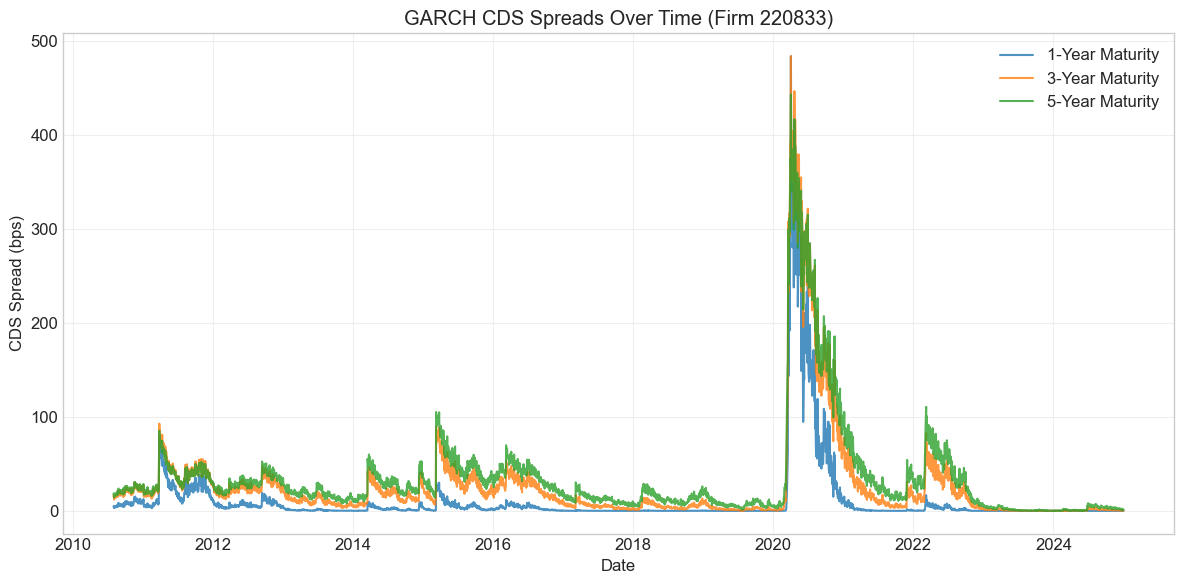

In [38]:
# Plot for firm 14447 
plotter.plot_spreads_over_time('GARCH', gvkey=220833, maturities=[1, 3, 5])

## 2. Regime Switching Model Results
Visualizing the term structure of CDS spreads over time for the Regime Switching model.

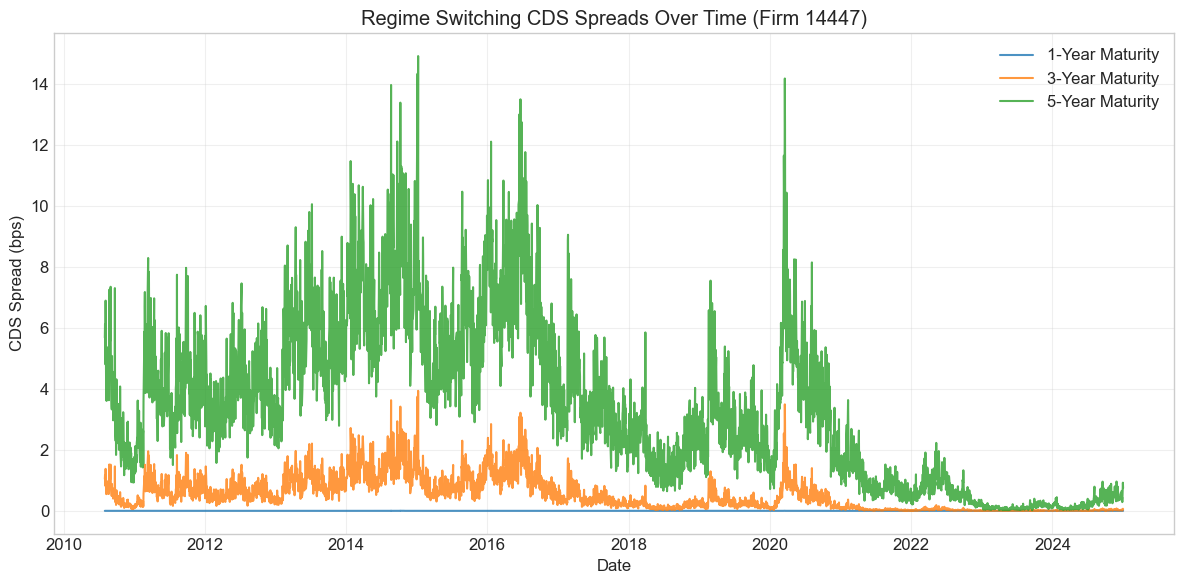

In [52]:
plotter.plot_spreads_over_time('Regime Switching', gvkey=14447, maturities=[1, 3, 5])

## 3. Model Comparison
Comparing the 5-year CDS spread estimates between models.

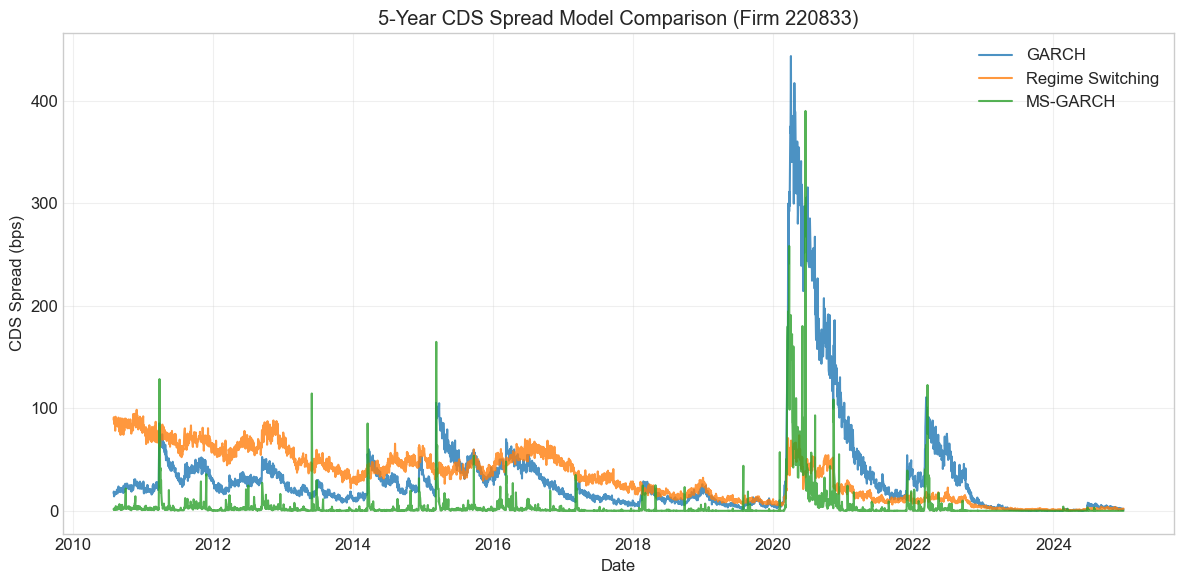

In [40]:
plotter.plot_model_comparison(gvkey=220833, maturity=5, models=['GARCH', 'Regime Switching', 'MS-GARCH'])

## 4. Average Spreads Across All Firms
Visualizing the average CDS spreads for all firms in the dataset (GARCH model).

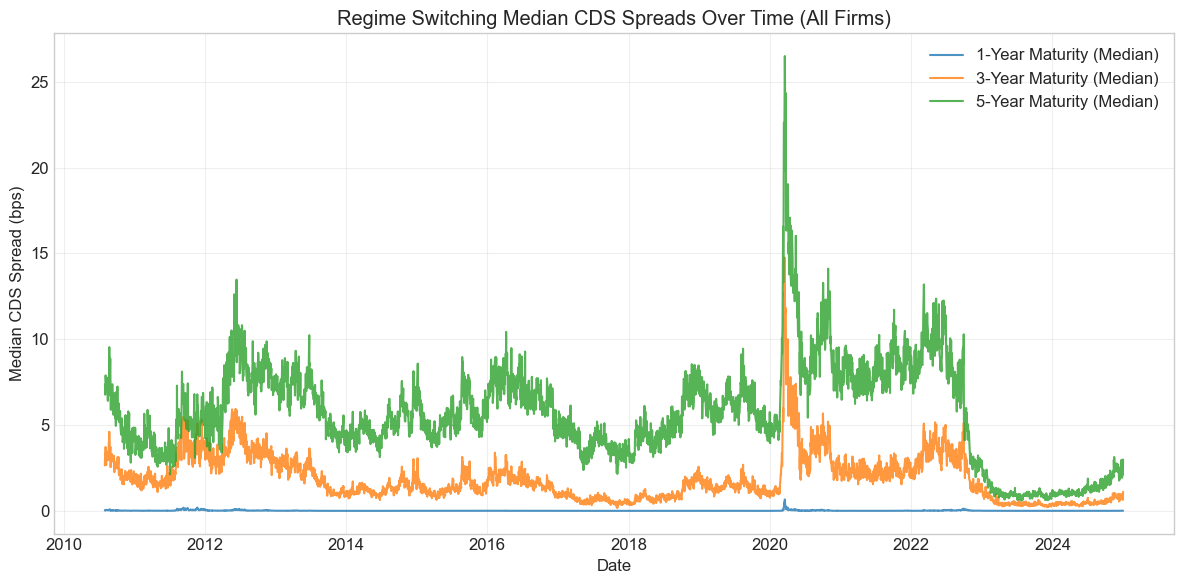

In [51]:
plotter.plot_average_spreads_over_time('Regime Switching', maturities=[1, 3, 5])

## 5. Model vs Market CDS Comparison

Comparing model-implied CDS spreads with actual market CDS data to evaluate model performance.

In [ ]:
def prepare_cds_comparison(gvkey, maturity, market_df, model_df, model_name):
    """
    Prepare a comparison dataframe between market and model CDS spreads.
    
    Parameters:
    -----------
    gvkey : int
        Firm identifier
    maturity : int
        CDS maturity in years (1, 3, or 5)
    market_df : pd.DataFrame
        Market CDS data with columns ['date', 'gvkey', 'cds']
    model_df : pd.DataFrame
        Model CDS data with columns ['date', 'gvkey', 'cds_Xy'] where X is maturity
    model_name : str
        Name of the model for labeling
    
    Returns:
    --------
    pd.DataFrame with columns ['date', 'market_cds', 'model_cds', 'model']
    """
    # Filter for specific firm
    market_firm = market_df[market_df['gvkey'] == gvkey][['date', 'cds']].copy()
    market_firm.columns = ['date', 'market_cds']
    
    # Get model CDS for this maturity
    model_col = f'cds_{maturity}y'
    model_firm = model_df[model_df['gvkey'] == gvkey][['date', model_col]].copy()
    model_firm.columns = ['date', 'model_cds']
    
    # Merge
    comparison = pd.merge(market_firm, model_firm, on='date', how='inner')
    comparison['model'] = model_name
    
    return comparison

print('✓ Helper function defined')

In [ ]:
# Example: Compare market vs model CDS for a specific firm
# Use gvkey 220833 (or any other firm of interest) for 5-year maturity
plot_firm_cds_comparison(gvkey=220833, maturity=5)

In [ ]:
# Example: Get unique firm IDs from market data
unique_firms = cds_5y[['gvkey', 'company']].drop_duplicates().head(6)
print("Sample firms in dataset:")
print(unique_firms)

# Plot comparison for first 6 firms
example_gvkeys = unique_firms['gvkey'].tolist()
plot_multiple_firms_single_model(example_gvkeys, model_name='GARCH', maturity=5)